Problem Statement 1:
A retail store that has multiple outlets across the country are facing issues in managing the inventory - to match the demand with respect to supply.
Dataset Information:
The walmart.csv contains 6435 rows and 8 columns.
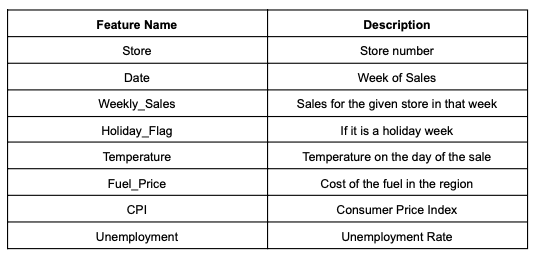

1. You are provided with the weekly sales data for their various outlets. Use statistical analysis, EDA, outlier analysis, and handle the missing values to come up with various insights that can give them a clear perspective on the following:

a. If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?

b. If the weekly sales show a seasonal trend, when and what could be the reason?

c. Does temperature affect the weekly sales in any manner?

d. How is the Consumer Price index affecting the weekly sales of various stores?

e. Top performing stores according to the historical data.

f. The worst performing store, and how significant is the difference between the highest and lowest performing stores.

2. Use predictive modeling techniques to forecast the sales for each store for the next 12 weeks.

#Data Preprocessing and Exploratory Data Analysis (EDA)

In [14]:
#Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import itertools

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Load the dataset
data = pd.read_csv('Walmart.csv')

# Display the first few rows of the dataset
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
# Display the number of rows and columns
data.shape

(6435, 8)

In [4]:
# Display number of stores
data['Store'].nunique()

45

In [5]:
# Display first and last 5 rows
data['Date'].head(5).append(data['Date'].tail(5))

<ipython-input-5-fecb8ece152a>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data['Date'].head(5).append(data['Date'].tail(5))


0       05-02-2010
1       12-02-2010
2       19-02-2010
3       26-02-2010
4       05-03-2010
6430    28-09-2012
6431    05-10-2012
6432    12-10-2012
6433    19-10-2012
6434    26-10-2012
Name: Date, dtype: object

Our data is from 5th of February 2010 to 26th of October 2012.


In [6]:
# Check the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
# Check statistical information
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


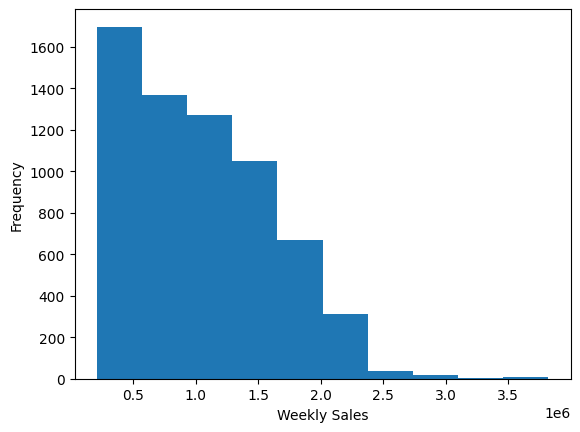

In [27]:
# Weekly Sales distribution
plt.hist(data["Weekly_Sales"])
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")
plt.show()

#Data Cleaning and Handling Missing Values

In [3]:
# Convert 'Date' column to datetime format with specified date format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [9]:
# Check for missing values
print(data.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


There are no missing values

In [4]:
# Convert 'Store', 'Holiday_Flag' to categorical type
data['Holiday_Flag'] = data['Holiday_Flag'].astype('category')
data['Store'] = data['Store'].astype('category')

#Outlier Analysis

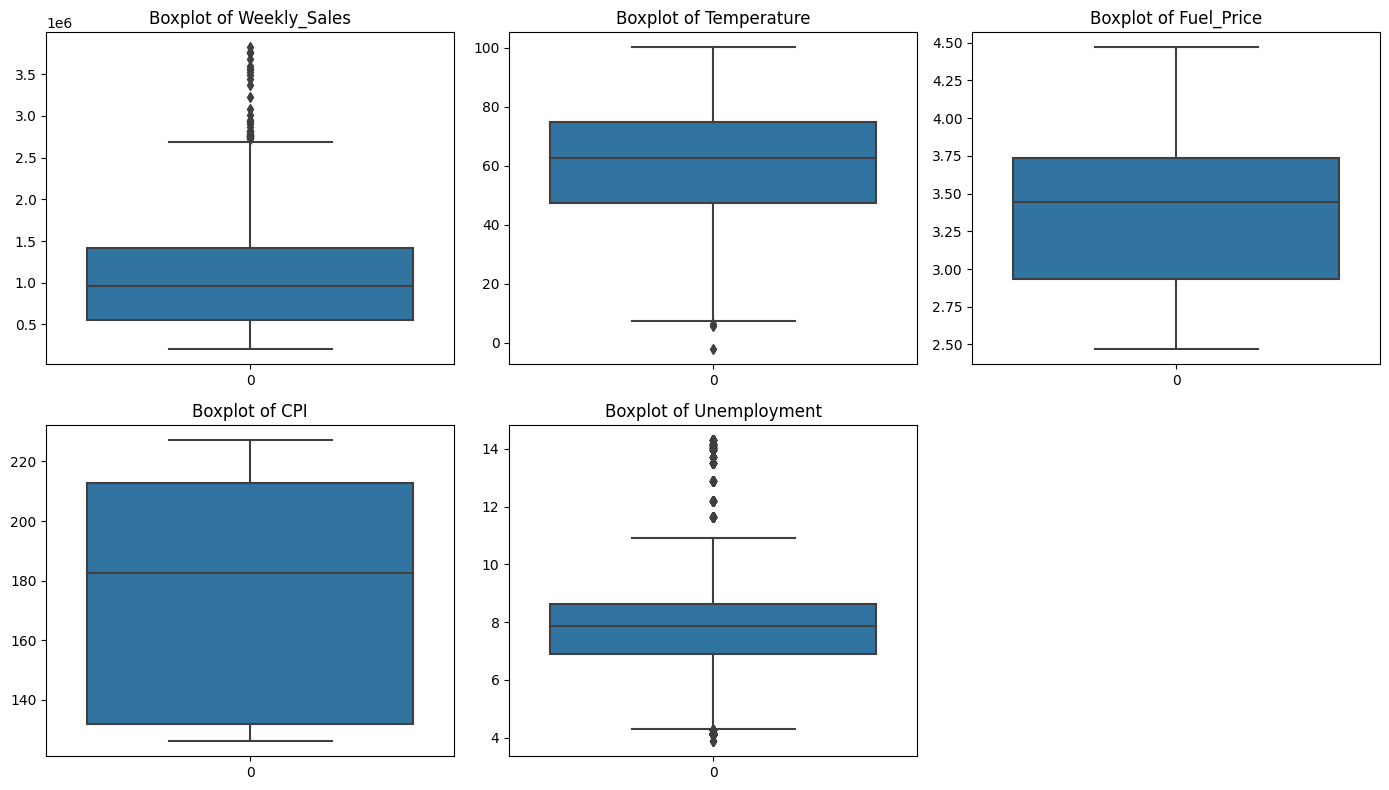

In [30]:
# Selecting only numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Plotting boxplots for each numeric column to identify outliers
plt.figure(figsize=(14, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

plt.show()

The size of the stores could be a contributing factor to the outliers observed in some of the box plots. Larger stores typically have more inventory and floor space, which allows them to cater to a wider range of customers and potentially generate higher weekly sales. Consequently, their sales data might deviate significantly from the IQR, making them appear as outliers.

However, it's important to note that store size is likely just one piece of the puzzle. Other factors, such as location, demographics of the surrounding community, product mix, and competitive landscape, can also significantly impact weekly sales.

#Visualisation

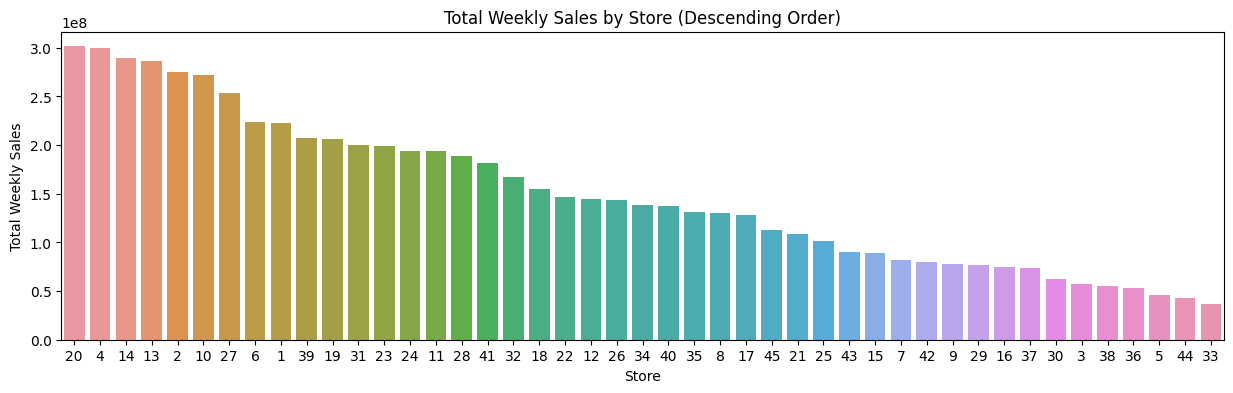

In [15]:
# Calculate total weekly sales for each store
total_sales_per_store = data.groupby('Store')['Weekly_Sales'].sum().reset_index()

# Sort stores by total weekly sales in descending order
total_sales_per_store = total_sales_per_store.sort_values(by='Weekly_Sales', ascending=False)

# Plotting the bar plot
plt.figure(figsize=(15, 4))
sns.barplot(x='Store', y='Weekly_Sales', data=total_sales_per_store, order=total_sales_per_store['Store'])
plt.title('Total Weekly Sales by Store (Descending Order)')
plt.xlabel('Store')
plt.ylabel('Total Weekly Sales')
plt.show()

#Weekly sales vs Unemployment rate by Store

<ipython-input-7-bfc6a3a8b854>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


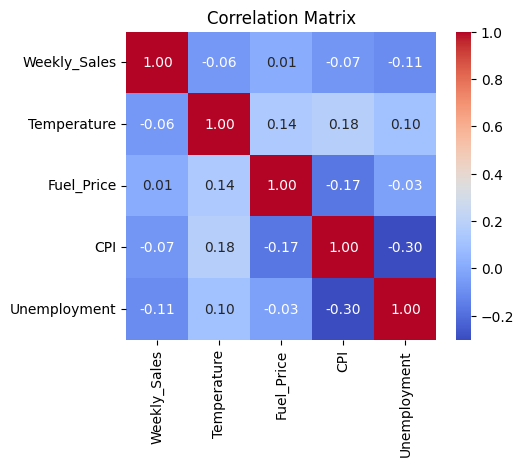

In [7]:
# Correlation matrix
corr = data.corr()

# Plotting a heatmap with correlation values
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

A correlation coefficient of -0.11 between Unemployment Rate and Weekly Sales indicates a weak negative linear relationship between these two variables.

Interpreting a correlation coefficient:

As the correlation coefficient is close to zero and negative, it suggests that there's a slight tendency for higher Unemployment Rates to be associated with slightly lower Weekly Sales.

Here are some possible interpretations of this correlation:

Increased unemployment may lead to lower disposable income: When people are unemployed, they have less money to spend, which could lead to lower spending at Walmart.
Unemployed people may change their shopping habits: Unemployed people may shop less frequently or switch to cheaper alternatives, which could also lead to lower sales at Walmart.

However, the strength of this relationship is not substantial, implying that changes in the Unemployment Rate only explain a small portion of the variation in Weekly Sales.

Other factors such as marketing strategies, consumer behavior, economic conditions, store locations, promotions, and more could be influencing Weekly Sales to a larger extent.

In [22]:
# Calculate correlation between Weekly Sales and Unemployment Rate for each store
correlation = data.groupby('Store')[['Weekly_Sales', 'Unemployment']].corr().iloc[0::2, -1].reset_index()

# Filter stores suffering the most (stores with the most negative correlation)
stores_most_suffering = correlation[correlation['Unemployment'] < 0].sort_values(by='Unemployment')['Store'].tolist()

print("Stores suffering the most due to Unemployment Rate:", stores_most_suffering)

Stores suffering the most due to Unemployment Rate: [38, 44, 39, 42, 41, 4, 17, 3, 37, 5, 43, 9, 13, 7, 40, 32, 1, 20, 23, 16, 26, 31, 8, 11, 27, 24, 12, 25, 45]


**The list indicates the stores suffering the most due to the negative correlation between Unemployment Rate and Weekly Sales. These stores are listed in descending order of their negative correlation values.**

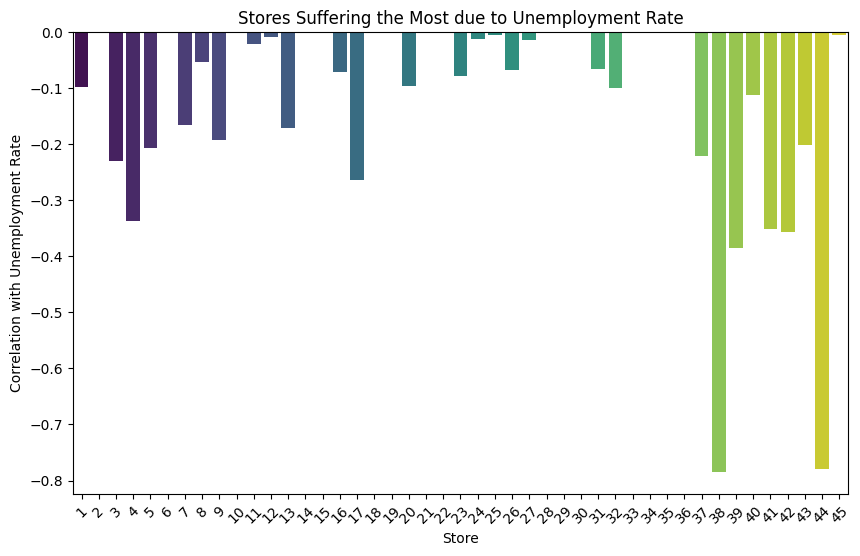

In [24]:
# Filter stores suffering the most (stores with the most negative correlation)
stores_most_suffering = correlation[correlation['Unemployment'] < 0].sort_values(by='Unemployment')

# Plotting a bar plot to visualize stores suffering the most due to Unemployment Rate
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Store', y='Unemployment', data=stores_most_suffering, palette='viridis')
plt.title('Stores Suffering the Most due to Unemployment Rate')
plt.xlabel('Store')
plt.ylabel('Correlation with Unemployment Rate')
plt.xticks(rotation=45)
plt.show()

**It can be seen that Store 38, Store 44 have the most negative correlation values among all the stores in the dataset. This implies that these stores are more affected by changes in the Unemployment Rate, showing a tendency for their Weekly Sales to decrease when the Unemployment Rate increases.**

#Seasonal Trend Analysis

In [5]:
# Extract month and year from the 'Date' column
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Week'] =data['Date'].dt.week

<ipython-input-5-ff5a33c13a4e>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['Week'] =data['Date'].dt.week


In [8]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year,Week
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010,6
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010,7
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010,8
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010,9


In [10]:
# Calculate average sales for different months
data.groupby('Month')['Weekly_Sales'].mean().map('{:.2f}'.format)

Month
1      923884.55
2     1053199.80
3     1013309.23
4     1026761.56
5     1031714.02
6     1064324.59
7     1031747.58
8     1048017.45
9      989335.35
10     999632.12
11    1147265.90
12    1281863.63
Name: Weekly_Sales, dtype: object

There is a notable increase in average weekly sales during these months, escalating from 1,147,265.90 in November to 1,281,863.63 in December.

**Seasonal Variations:** This rise aligns with holiday seasons like Thanksgiving and Christmas, indicating increased consumer spending during these festive periods.

**Stable Periods:** Months from January to August demonstrate relatively consistent sales levels, suggesting stable consumer behavior during these months, potentially unaffected by major holidays or events.

In [40]:
# Calculate average weekly sales for each year
data.groupby('Year')['Weekly_Sales'].mean().map('{:.2f}'.format)

Year
2010    1059669.50
2011    1046239.32
2012    1033660.39
Name: Weekly_Sales, dtype: object

**Yearly Sales Trends:** The data indicates a relatively consistent average weekly sales performance across the three years.

**Slight Decline:** There is a slight downward trend observed in average weekly sales from 2010 to 2012.

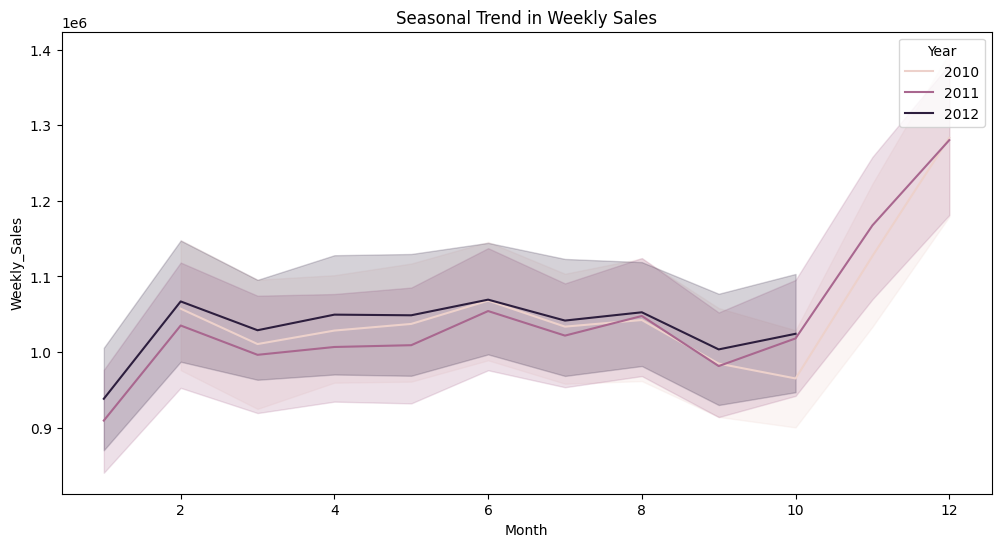

In [11]:
# Visualize seasonal trend in sales
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Weekly_Sales', hue='Year', data=data)
plt.title('Seasonal Trend in Weekly Sales')
plt.show()

The graph illustrates the seasonal trends in weekly sales across months for the years 2010, 2011, and a partial representation of 2012. Several observations can be made:

**2011 Exhibits Lower Sales Compared to 2010:**

Throughout most months, the sales trend for 2011 consistently appears lower compared to 2010, as indicated by the lower position of the blue line (representing 2011) concerning the red line (representing 2010).

**2012's Incomplete Data and Comparative Mean Sales:**

The data for 2012 appears incomplete, lacking information for November and December, which are months known to have higher sales, especially during holiday seasons.
Despite the absence of sales data for these two crucial months in 2012, the mean sales for the available months in 2012 are notably closer to 2010's mean sales.

**Potential Performance of 2012 with Full Data:**

If the sales data for November and December in 2012 were available and if they aligned with typical high sales trends for these months, it's likely that 2012's overall mean sales would surpass both 2010 and 2011.
This assumption is based on the proximity of 2012's existing mean to 2010's mean despite the absence of the last two months' sales data.

In [13]:
# Calculate top 5 weeks with the highest average weekly sales
top_5_weeks = data.groupby('Week')['Weekly_Sales'].mean().sort_values(ascending=False).head(5).map('{:.2f}'.format)
print(top_5_weeks)

Week
51    1754773.97
47    1471273.43
50    1354516.62
49    1235865.76
48    1103328.72
Name: Weekly_Sales, dtype: object


<ipython-input-15-ae13121017c6>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Week', y='Weekly_Sales', hue='Year', data=data, ci=None)


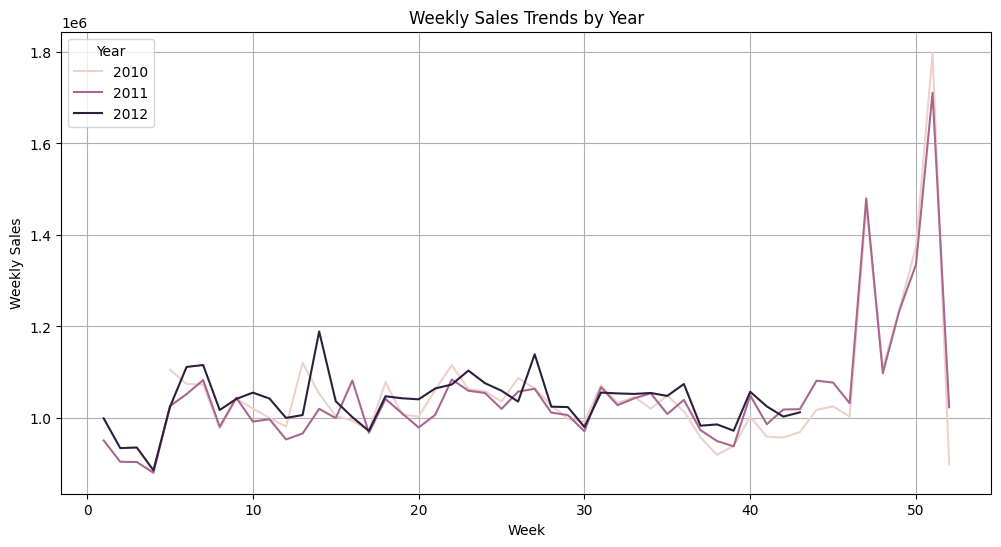

In [15]:
# Plotting weekly sales trends for different years
plt.figure(figsize=(12, 6))
sns.lineplot(x='Week', y='Weekly_Sales', hue='Year', data=data, ci=None)
plt.title('Weekly Sales Trends by Year')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.legend(title='Year')
plt.grid(True)
plt.show()

The top 5 highest sales averages among the weeks seem to correlate with specific significant periods:

**1-2 Weeks Before Christmas:** Week 51, showcasing the highest sales average, aligns with the period just before Christmas, a time known for heightened shopping activities and increased consumer spending.

**Thanksgiving and Black Friday:** Week 47, another high-performing week, typically corresponds to Thanksgiving and Black Friday, renowned for substantial sales due to holiday shopping and promotional events.

**End of May (School Closure Period):** Week 50, holding a prominent position in the top 5, coincides with the end of May, potentially reflecting increased sales as schools are closing for summer vacations, leading to higher consumer activity.

Additional High-Performing Weeks: Weeks 49 (before Christmas) and 48 (leading up to December holidays) also manifest robust sales averages, likely associated with pre-holiday shopping sprees and festive preparations.

#Temperature vs Weekly Sales

In [9]:
correlation = data["Temperature"].corr(data["Weekly_Sales"])
print(f"Correlation coefficient between Temperature and Weekly Sales: {correlation:.2f}")

Correlation coefficient between Temperature and Weekly Sales: -0.06


**A correlation coefficient of -0.06 indicates a very weak negative relationship between temperature and weekly sales in your data. This means that there is almost no linear relationship between the two variables. i.e.,Higher temperatures don't necessarily lead to lower sales, and vice versa.**

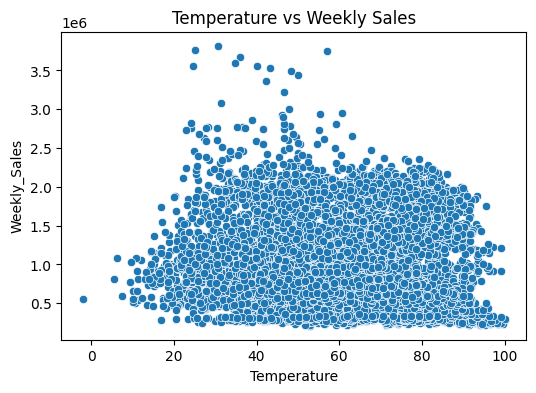

In [8]:
# Analyze temperature effect on sales
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=data)
plt.title('Temperature vs Weekly Sales')
plt.show()

In the realm of retail, it's widely acknowledged that weather significantly influences sales dynamics. Warmer weather often stimulates consumer spending, whereas extreme cold or hot conditions can deter shoppers from venturing out to make purchases. Typically, temperatures spanning from 40 to 80 degrees Fahrenheit are deemed favorable for human comfort, avoiding extremes of heat or cold.

As depicted in the data below, it's evident that the peak sales for most store types align within the range of 20 to 60 degrees Fahrenheit. This observation substantiates the notion that pleasant weather tends to increase higher sales figures. Conversely, sales exhibit a relative dip during very low and very high temperature ranges. However, within the favorable climate conditions, sales maintain a consistently robust performance, affirming the correlation between favorable weather and increased consumer spending habits.

#CPI vs Weekly Sales

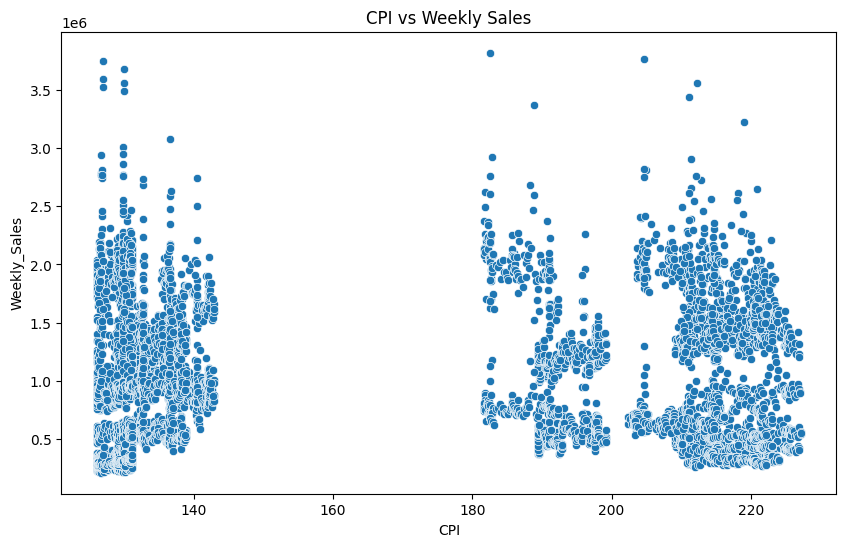

In [11]:
# Analyze CPI effect on sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CPI', y='Weekly_Sales', data=data)
plt.title('CPI vs Weekly Sales')
plt.show()

**In the scatter plot above, three distinct clusters can be seen across varying CPI ranges. Although no clear correlation is evident between CPI fluctuations and Walmart stores' weekly sales (sales remain consistent despite high CPI rates), a slight observation stands out. Specifically,  notably higher sales can be seen when CPI levels drop to a low rate of 140.**






In [16]:
# Compute the change in weekly sales and CPI
data['Sales_Change'] = data['Weekly_Sales'].diff()
data['CPI_Change'] = data['CPI'].diff()

# Calculate the correlation between the changes
correlation = data['Sales_Change'].corr(data['CPI_Change'])

print("Correlation between Weekly Sales Change and CPI Change:", correlation)

Correlation between Weekly Sales Change and CPI Change: -0.02534965136436141


**The correlation coefficient between the change in weekly sales and the change in CPI is approximately -0.025.**

**This negative correlation, though weak, suggests a slight inverse relationship between the fluctuations in weekly sales and CPI changes. It implies that as one variable slightly increases, the other tends to decrease slightly, and vice versa, but the relationship is not strong.**

#Top and Worst Performing Stores

In [18]:
# Top performing stores based on historical data
top_stores = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(5).map('{:.2f}'.format)
print("Top Performing Stores:")
print(top_stores)

Top Performing Stores:
Store
20    301397792.46
4     299543953.38
14    288999911.34
13    286517703.80
2     275382440.98
Name: Weekly_Sales, dtype: object


In [20]:
# Worst performing store
worst_store = data.groupby('Store')['Weekly_Sales'].sum().idxmin()
print("Worst Performing Store:", worst_store)

Worst Performing Store: 33


In [21]:
# Calculate the difference between highest and lowest performing stores
sales_by_store = data.groupby('Store')['Weekly_Sales'].sum()
difference = sales_by_store.max() - sales_by_store.min()
print("Difference between highest and lowest performing stores:", difference)

Difference between highest and lowest performing stores: 264237570.49999997


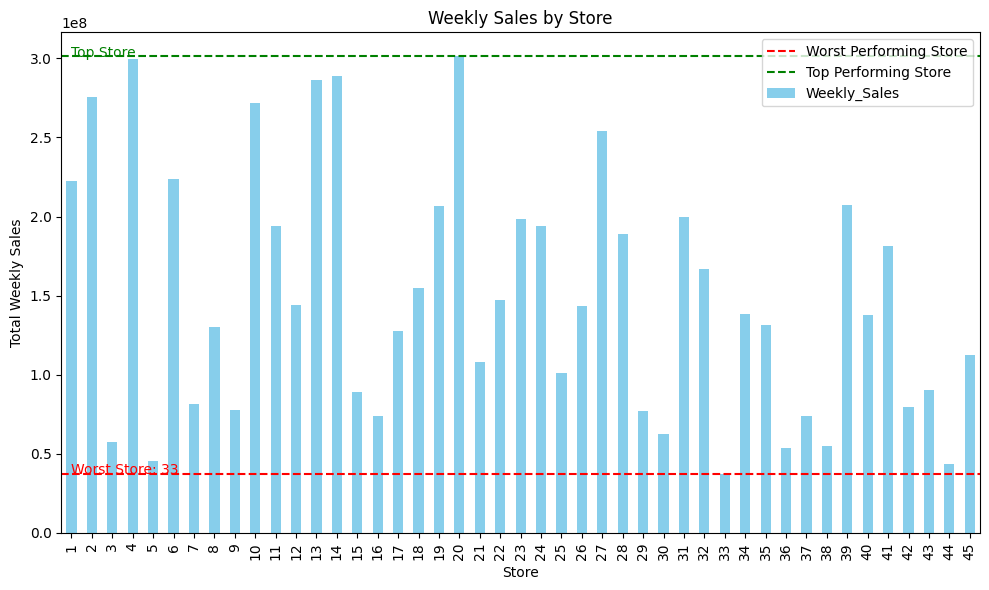

In [22]:
# Plotting the top performing stores, worst performing store, and their sales difference
plt.figure(figsize=(10, 6))
sales_by_store.plot(kind='bar', color='skyblue')
plt.axhline(y=sales_by_store[worst_store], color='red', linestyle='--', label='Worst Performing Store')
plt.text(0, sales_by_store[worst_store] + 100000, f'Worst Store: {worst_store}', color='red')
plt.axhline(y=sales_by_store.max(), color='green', linestyle='--', label='Top Performing Store')
plt.text(0, sales_by_store.max() - 300000, f'Top Store', color='green')
plt.title('Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Total Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

## **Predictive Modeling for Sales Forecast**

For sales forecasting in this dataset, where we have time-related data and multiple stores, several modeling techniques can be applied. However, in this case we will be using Seasonal ARIMA (SARIMA), as the main advantage is that SARIMA models handle seasonal data well, capturing both seasonality and trends.

There are 45 stores' data available in the dataset. Here we will be predicting the Weekly sales of about 5 stores. Let's predict for the stores 20, 33, 32, 38, 25

In [6]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year,Week
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010,6
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010,7
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010,8
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010,9


In [7]:
# Convert 'Date' column to datetime and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [8]:
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year,Week
Date,,,,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010,5
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010,6
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010,7
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010,8
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010,9


In [21]:
# Function to perform forecasting for a specific store

def forecast_store_sales(store_number):

    store = data[data['Store'] == store_number]
    sales = pd.DataFrame(store['Weekly_Sales'].groupby(store.index).sum())

    sales.reset_index(inplace=True)
    sales['Date'] = pd.to_datetime(sales['Date'])
    sales.set_index('Date', inplace=True)

    # Plot weekly sales using Plotly
    sales_fig = go.Figure()
    sales_fig.add_trace(go.Scatter(x=sales.index, y=sales['Weekly_Sales'], mode='lines', name='Weekly Sales'))
    sales_fig.update_layout(title='Weekly Sales of a Store', xaxis_title='Date', yaxis_title='Sales')
    sales_fig.show()

    decomposition = seasonal_decompose(sales['Weekly_Sales'], period=12)
    decomposition_fig = decomposition.plot()
    decomposition_fig.show()

    p = d = q = range(0, 5)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

    mod = sm.tsa.statespace.SARIMAX(sales['Weekly_Sales'], order=(4, 4, 3), seasonal_order=(1, 1, 0, 52),
                                    enforce_invertibility=False)
    results = mod.fit()

    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()

    pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = sales['Weekly_Sales']['2010':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Sales')
    plt.legend()
    plt.show()

    y_forecasted = pred.predicted_mean
    y_truth = sales['Weekly_Sales']['2012-7-27':]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

    pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    ax = sales['Weekly_Sales']['2010':].plot(label='observed', figsize=(12, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
    ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-7-26'), sales.index[-1], alpha=.1, zorder=-1)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Sales')
    plt.legend()
    plt.show()

    y_forecasted = pred_dynamic.predicted_mean
    rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
    Residual = y_forecasted - y_truth
    print("Residual for Store {}: {}".format(store_number, np.abs(Residual).sum()))

    pred_uc = results.get_forecast(steps=12)
    pred_ci = pred_uc.conf_int()

    # Plotting forecast using Plotly
    forecast_fig = go.Figure()
    forecast_fig.add_trace(go.Scatter(x=sales.index, y=sales['Weekly_Sales'], mode='lines', name='observed'))
    forecast_fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_uc.predicted_mean, mode='lines', name='Forecast'))
    forecast_fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0], mode='lines', name='Lower Bound'))
    forecast_fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1], mode='lines', name='Upper Bound'))
    forecast_fig.update_layout(title=f'Forecast for Store {store_number}', xaxis_title='Time Period', yaxis_title='Sales')
    forecast_fig.show()

    # Creating a table for forecast of next 12 weeks
    forecast_table = pd.DataFrame({'Lower Bound': pred_ci.iloc[:, 0], 'Forecast': pred_uc.predicted_mean, 'Upper Bound': pred_ci.iloc[:, 1]})
    # Suppress scientific notation
    pd.set_option('display.float_format', lambda x: '%.0f' % x)

    print(forecast_table)

Enter the store id to forecast sales: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9741      0.127    -15.604      0.000      -2.222      -1.726
ar.L2         -1.6429      0.272     -6.039      0.000      -2.176      -1.110
ar.L3         -0.9232      0.246     -3.756      0.000      -1.405      -0.441
ar.L4         -0.2829      0.090     -3.136      0.002      -0.460      -0.106
ma.L1         -0.9986      0.216     -4.630      0.000      -1.421      -0.576
ma.L2         -0.9513      0.097     -9.855      0.000      -1.141      -0.762
ma.L3          0.9576      0.172      5.555      0.000       0.620       1.295
ar.S.L52      -0.2019      0.077     -2.608      0.009      -0.354      -0.050
sigma2       6.11e+10    5.8e-12   1.05e+22      0.000    6.11e+10    6.11e+10


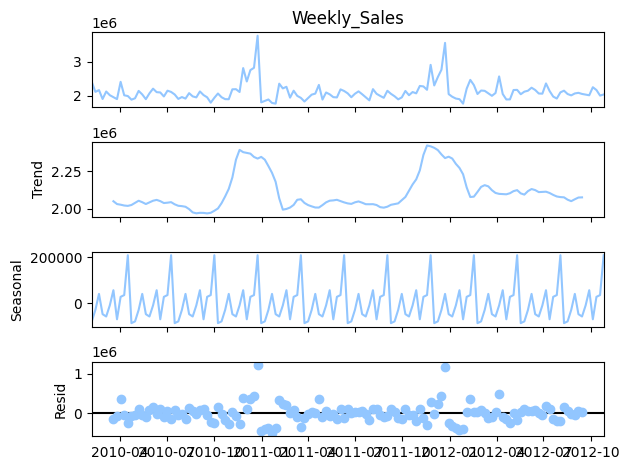

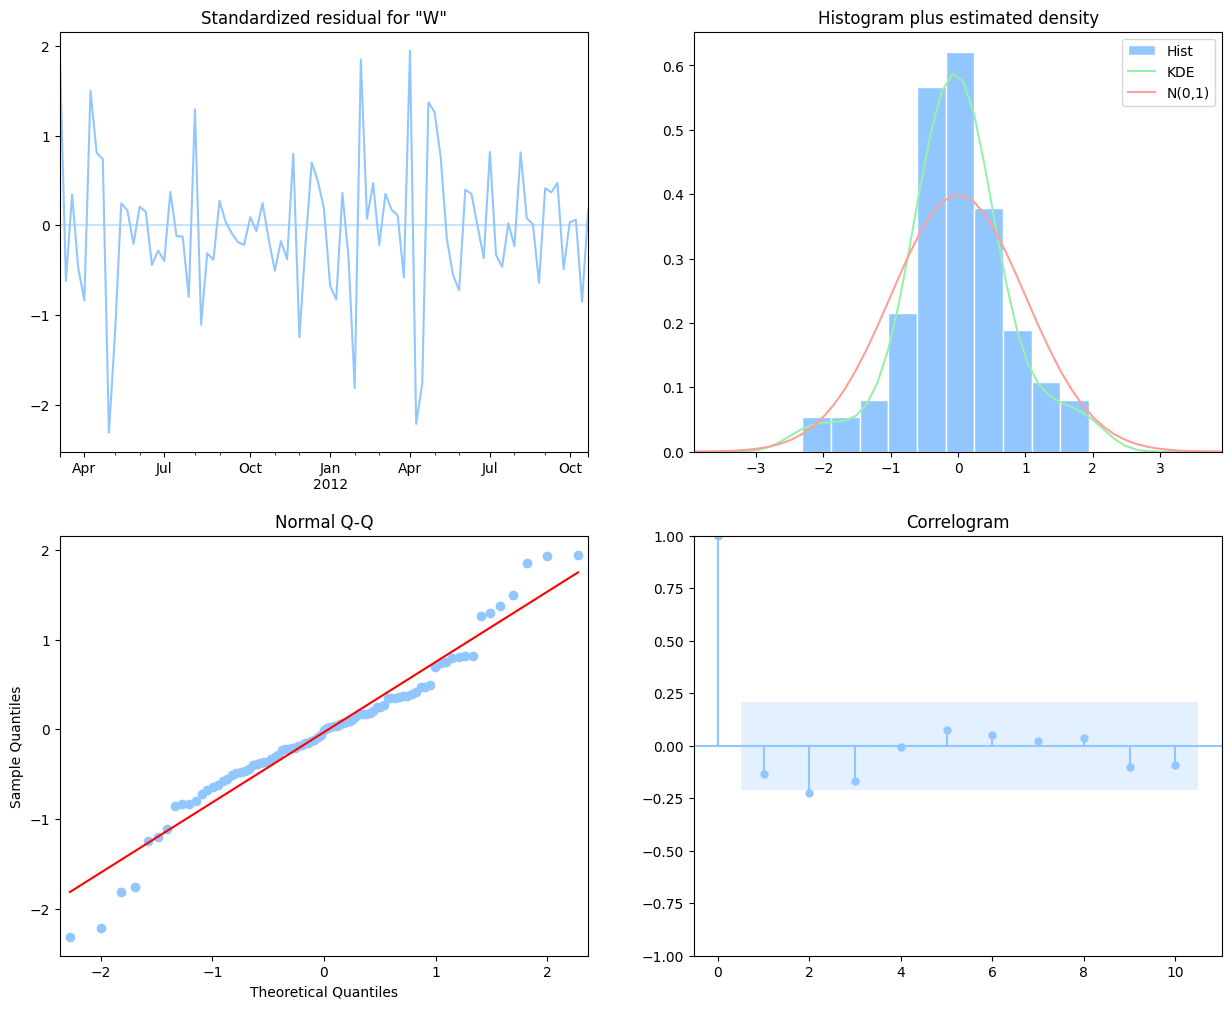

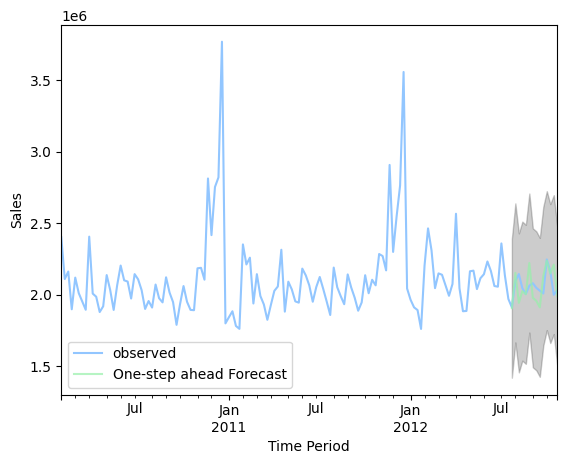

The Mean Squared Error of our forecasts is 11654527340.31


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



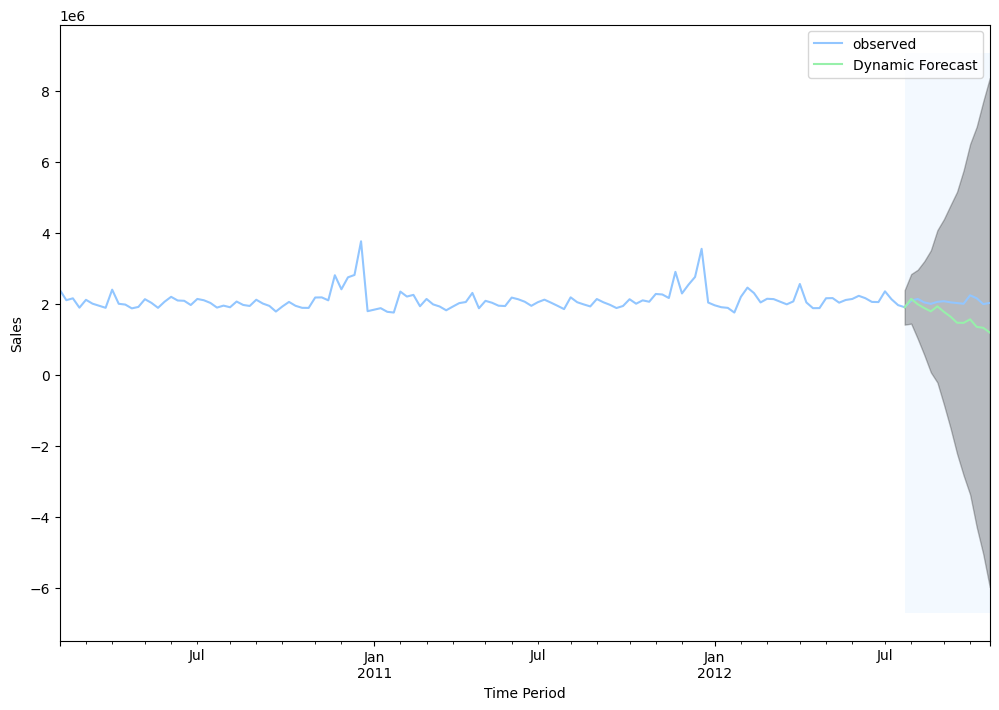

The Root Mean Squared Error of our forecasts is 478093.65
Residual for Store 20: 5475431.091219181


            Lower Bound  Forecast  Upper Bound
2012-11-02      1705802   2190937      2676072
2012-11-09      1436792   2133211      2829631
2012-11-16       980480   1949363      2918246
2012-11-23      1336261   2651360      3966460
2012-11-30       290582   2000377      3710172
2012-12-07        70613   2204094      4337575
2012-12-14      -285764   2309398      4904560
2012-12-21       -50896   3063328      6177552
2012-12-28     -2291627   1368614      5028855
2013-01-04     -3028021   1232544      5493110
2013-01-11     -3792124   1102845      5997813
2013-01-18     -4612258    973499      6559255


In [22]:
# Ask user for the store number
store_id = int(input("Enter the store id to forecast sales: "))
forecast_store_sales(store_id)

Enter the store id to forecast sales: 5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0495      0.493     -2.127      0.033      -2.017      -0.082
ar.L2         -0.7187      0.474     -1.517      0.129      -1.647       0.210
ar.L3         -0.5037      0.299     -1.685      0.092      -1.090       0.082
ar.L4         -0.2407      0.181     -1.330      0.183      -0.595       0.114
ma.L1         -1.9162      0.535     -3.580      0.000      -2.965      -0.867
ma.L2          0.8744      0.980      0.893      0.372      -1.045       2.794
ma.L3          0.0459      0.471      0.097      0.923      -0.878       0.970
ar.S.L52      -0.1555      0.061     -2.563      0.010      -0.274      -0.037
sigma2      9.034e+08   7.52e-10    1.2e+18      0.000    9.03e+08    9.03e+08


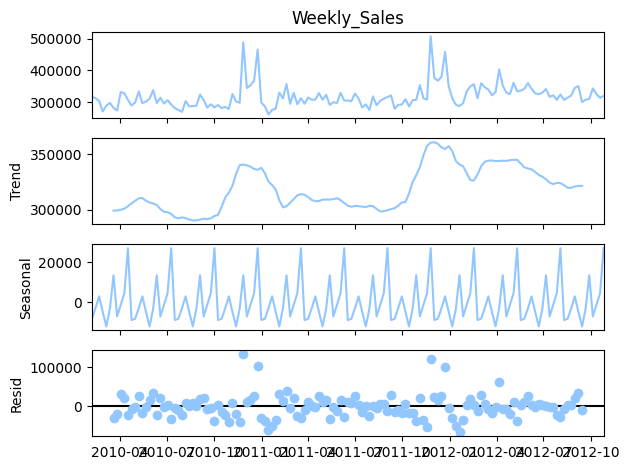

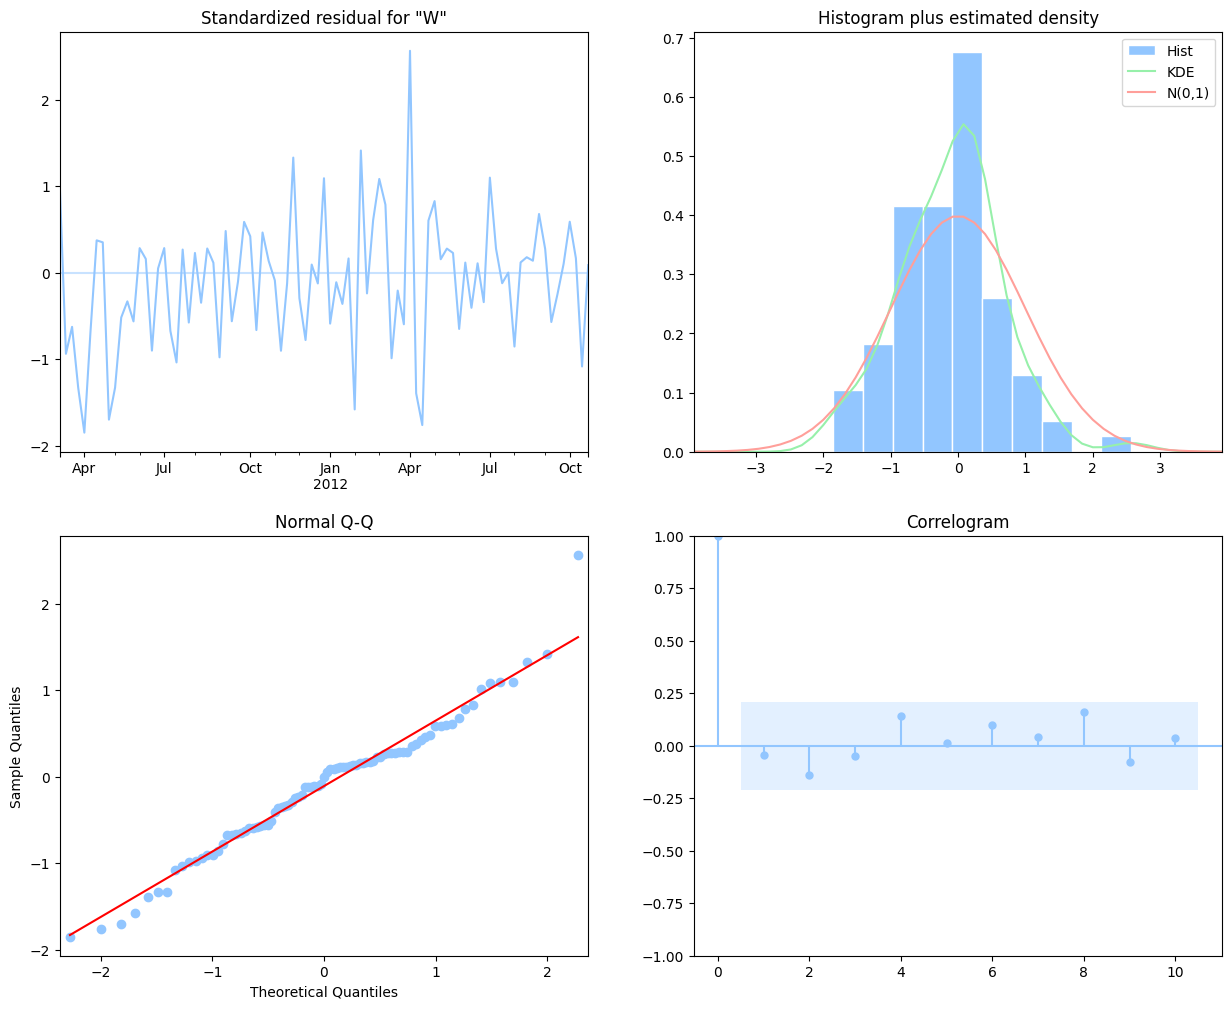

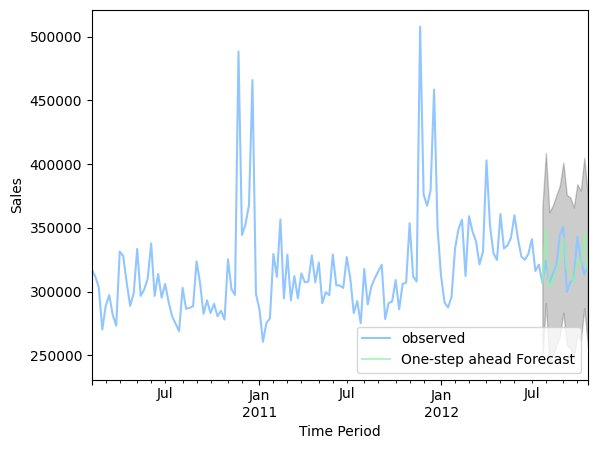

The Mean Squared Error of our forecasts is 212611721.73


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



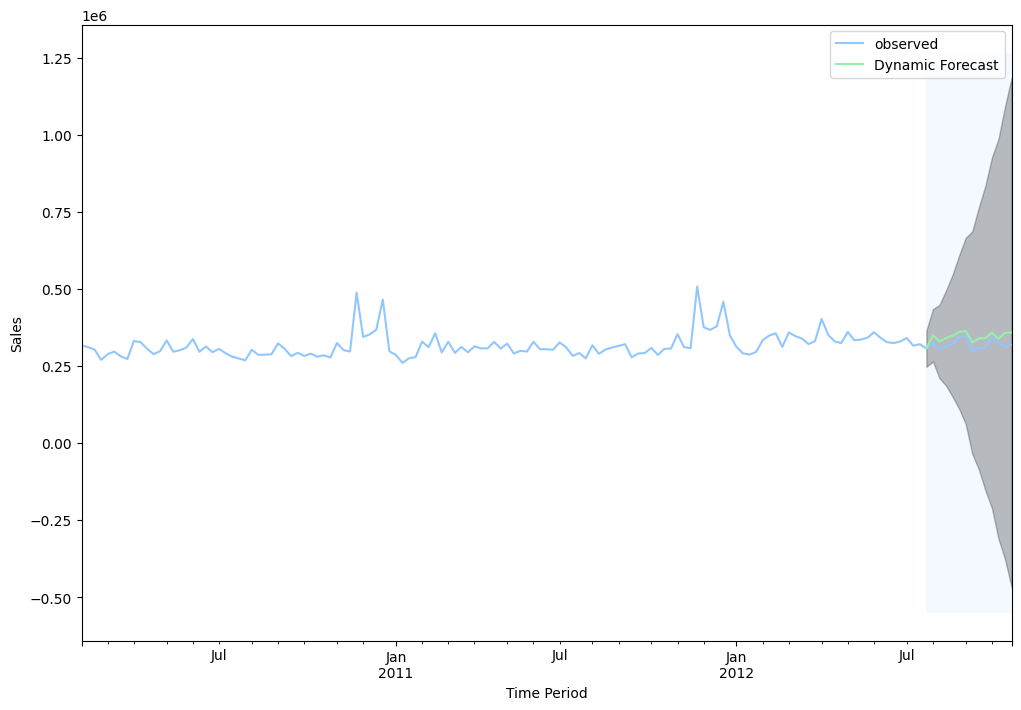

The Root Mean Squared Error of our forecasts is 26450.27
Residual for Store 5: 335427.33588246274


            Lower Bound  Forecast  Upper Bound
2012-11-02       302812    361776       420741
2012-11-09       238417    323321       408225
2012-11-16       192747    311528       430310
2012-11-23       349494    503591       657688
2012-11-30       169979    367582       565185
2012-12-07       107927    356125       604323
2012-12-14        63089    364130       665171
2012-12-21        80272    439832       799393
2012-12-28      -106057    316519       739095
2013-01-04      -214050    277496       769041
2013-01-11      -315503    250106       815715
2013-01-18      -401957    242989       887935


In [23]:
# Ask user for the store number
store_id = int(input("Enter the store id to forecast sales: "))
forecast_store_sales(store_id)

Enter the store id to forecast sales: 33


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1949      1.795     -0.666      0.506      -4.714       2.324
ar.L2         -0.7917      1.244     -0.636      0.525      -3.230       1.647
ar.L3         -0.4232      0.728     -0.581      0.561      -1.850       1.004
ar.L4         -0.1209      0.282     -0.429      0.668      -0.674       0.432
ma.L1         -1.4980      1.792     -0.836      0.403      -5.010       2.014
ma.L2          0.0345      3.568      0.010      0.992      -6.958       7.027
ma.L3          0.4685      1.796      0.261      0.794      -3.052       3.989
ar.S.L52      -0.1319      0.074     -1.781      0.075      -0.277       0.013
sigma2      4.799e+08   9.57e-09   5.02e+16      0.000     4.8e+08     4.8e+08


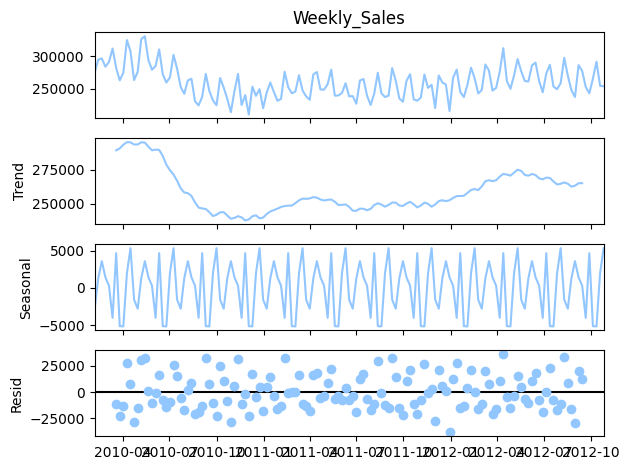

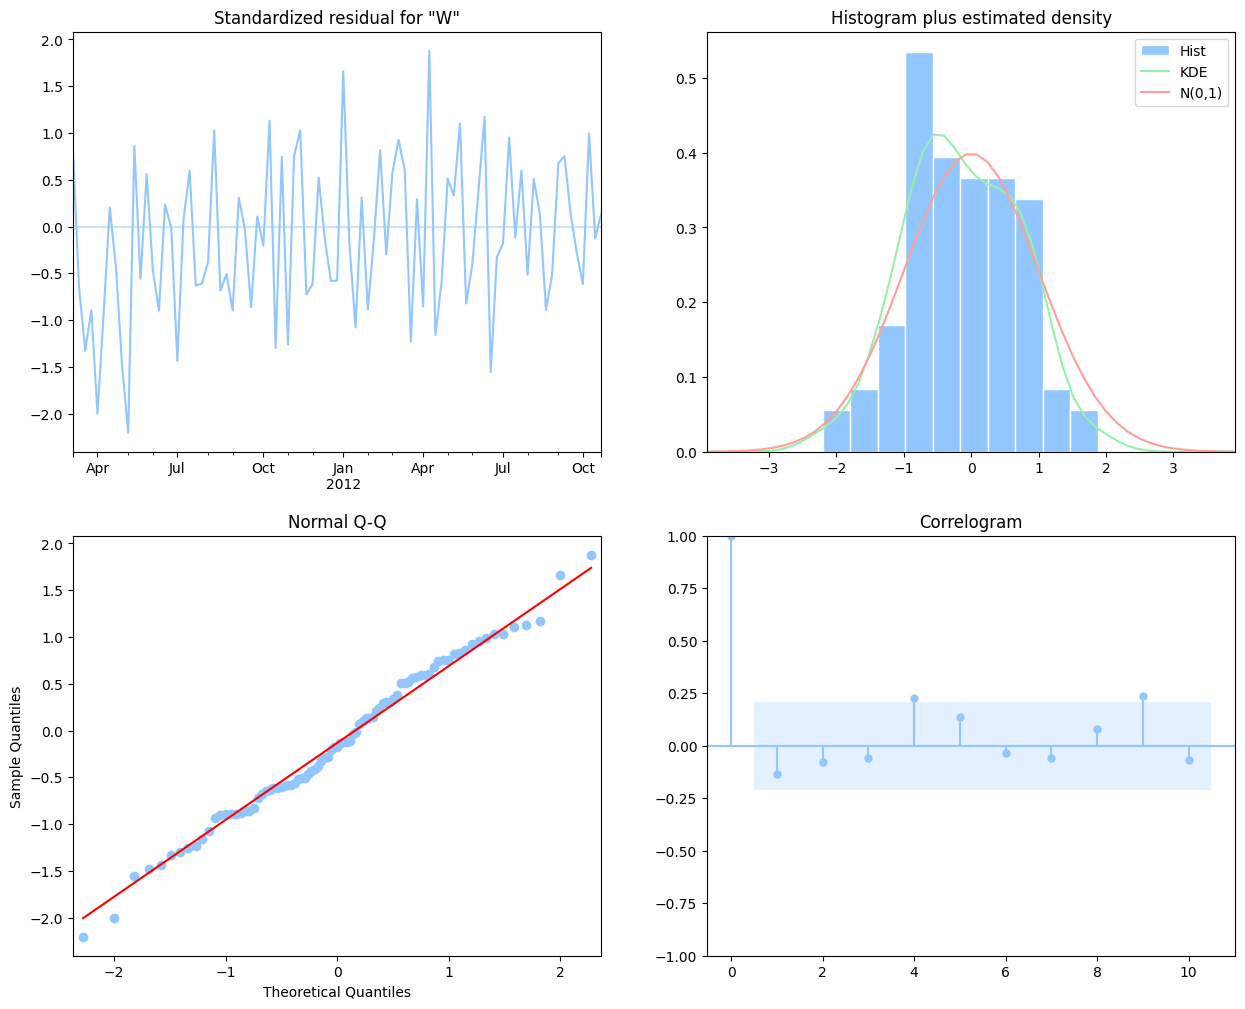

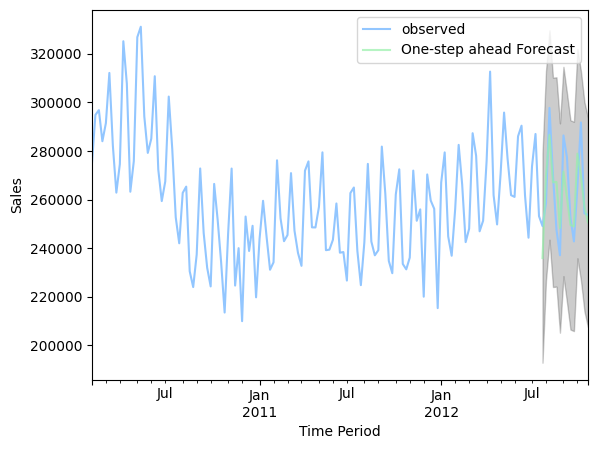

The Mean Squared Error of our forecasts is 154435731.33


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



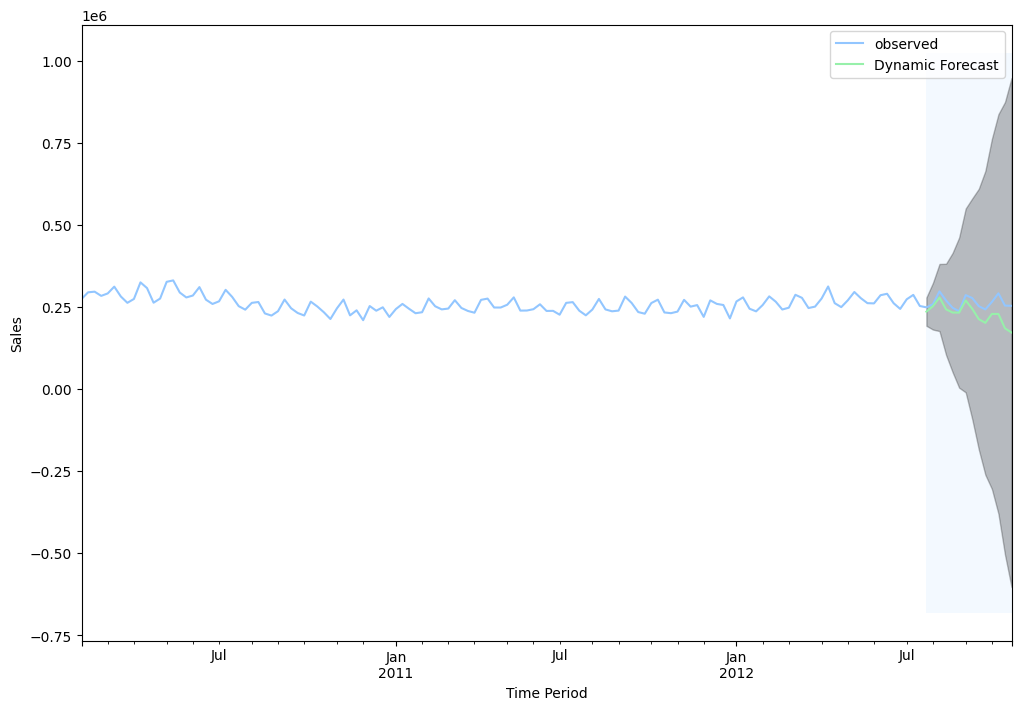

The Root Mean Squared Error of our forecasts is 40316.93
Residual for Store 33: 462504.4420522364


            Lower Bound  Forecast  Upper Bound
2012-11-02       222198    265257       308316
2012-11-09       233588    304644       375700
2012-11-16       181801    283873       385944
2012-11-23       154841    293287       431732
2012-11-30        80923    262032       443140
2012-12-07        87118    315116       543115
2012-12-14        28850    307761       586673
2012-12-21       -24625    309998       644621
2012-12-28      -120316    274666       669649
2013-01-04      -133154    326857       786868
2013-01-11      -185823    343947       873716
2013-01-18      -288000    316473       920947


In [24]:
# Ask user for the store number
store_id = int(input("Enter the store id to forecast sales: "))
forecast_store_sales(store_id)

Enter the store id to forecast sales: 38


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4816      0.782     -1.894      0.058      -3.014       0.051
ar.L2         -1.1879      0.802     -1.481      0.139      -2.760       0.385
ar.L3         -0.6156      0.465     -1.325      0.185      -1.527       0.295
ar.L4         -0.2219      0.159     -1.394      0.163      -0.534       0.090
ma.L1         -1.5790      0.820     -1.925      0.054      -3.187       0.029
ma.L2          0.2192      1.614      0.136      0.892      -2.945       3.383
ma.L3          0.3695      0.835      0.442      0.658      -1.268       2.007
ar.S.L52       0.0053      0.195      0.027      0.978      -0.376       0.387
sigma2       1.79e+09   1.38e-10   1.29e+19      0.000    1.79e+09    1.79e+09


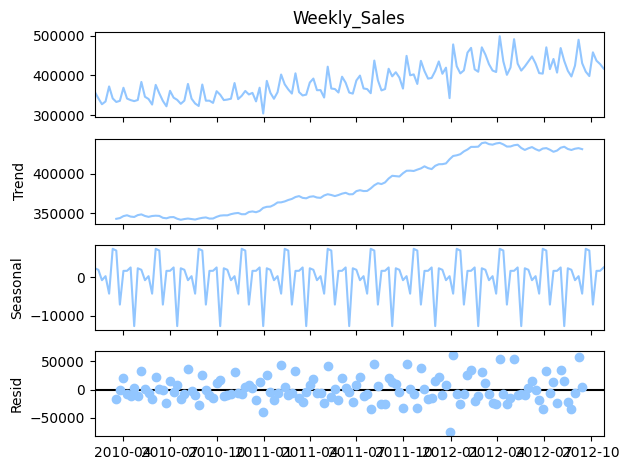

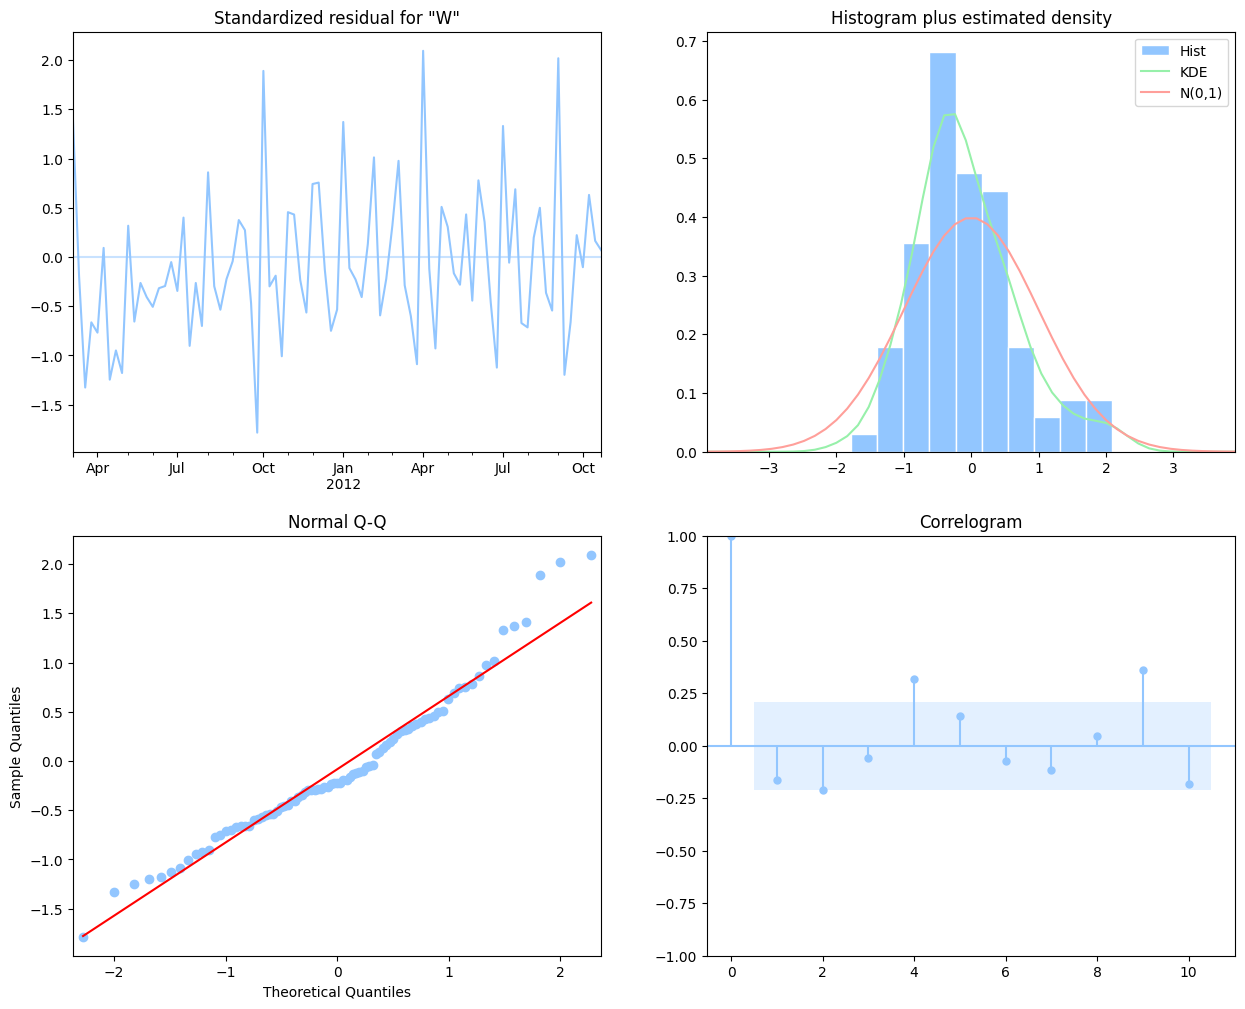

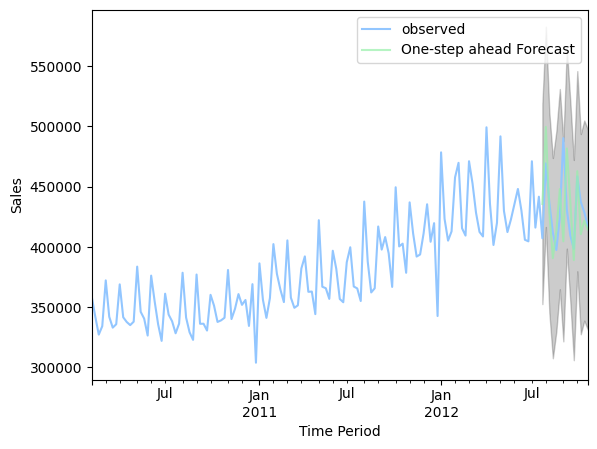

The Mean Squared Error of our forecasts is 1041568982.42


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



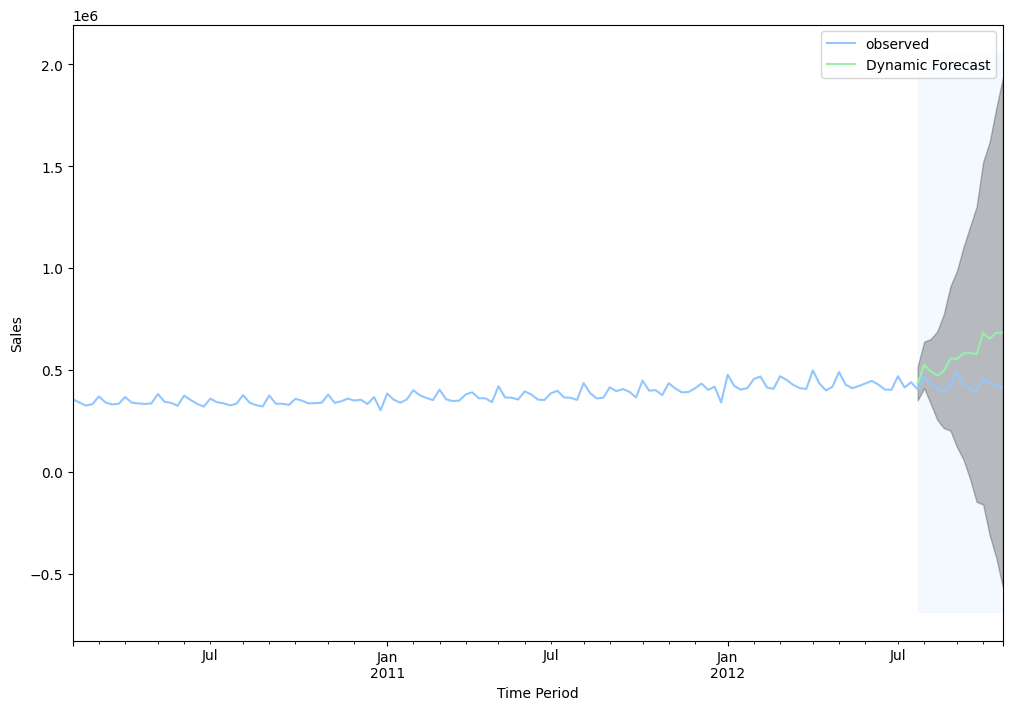

The Root Mean Squared Error of our forecasts is 161220.07
Residual for Store 38: 1975833.3623746242


            Lower Bound  Forecast  Upper Bound
2012-11-02       397946    481016       564085
2012-11-09       345193    459358       573523
2012-11-16       293584    452444       611305
2012-11-23       242129    458848       675567
2012-11-30       210077    489348       768619
2012-12-07       170210    523282       876353
2012-12-14        73978    504707       935436
2012-12-21        14159    534140      1054121
2012-12-28      -145337    471328      1087993
2013-01-04       -97591    624669      1346929
2013-01-11      -251022    586889      1424799
2013-01-18      -374087    588839      1551765


In [25]:
# Ask user for the store number
store_id = int(input("Enter the store id to forecast sales: "))
forecast_store_sales(store_id)

Enter the store id to forecast sales: 28


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4701      0.348     -1.352      0.176      -1.152       0.212
ar.L2          0.1256      0.360      0.349      0.727      -0.580       0.831
ar.L3          0.0420      0.296      0.142      0.887      -0.537       0.621
ar.L4          0.1271      0.192      0.661      0.509      -0.250       0.504
ma.L1         -2.8693      0.316     -9.091      0.000      -3.488      -2.251
ma.L2          2.7435      0.634      4.324      0.000       1.500       3.987
ma.L3         -0.8740      0.321     -2.720      0.007      -1.504      -0.244
ar.S.L52      -0.1634      0.076     -2.145      0.032      -0.313      -0.014
sigma2      2.827e+10    7.5e-11   3.77e+20      0.000    2.83e+10    2.83e+10


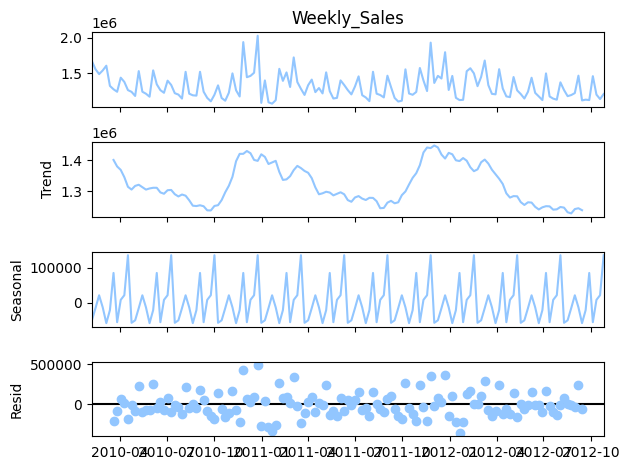

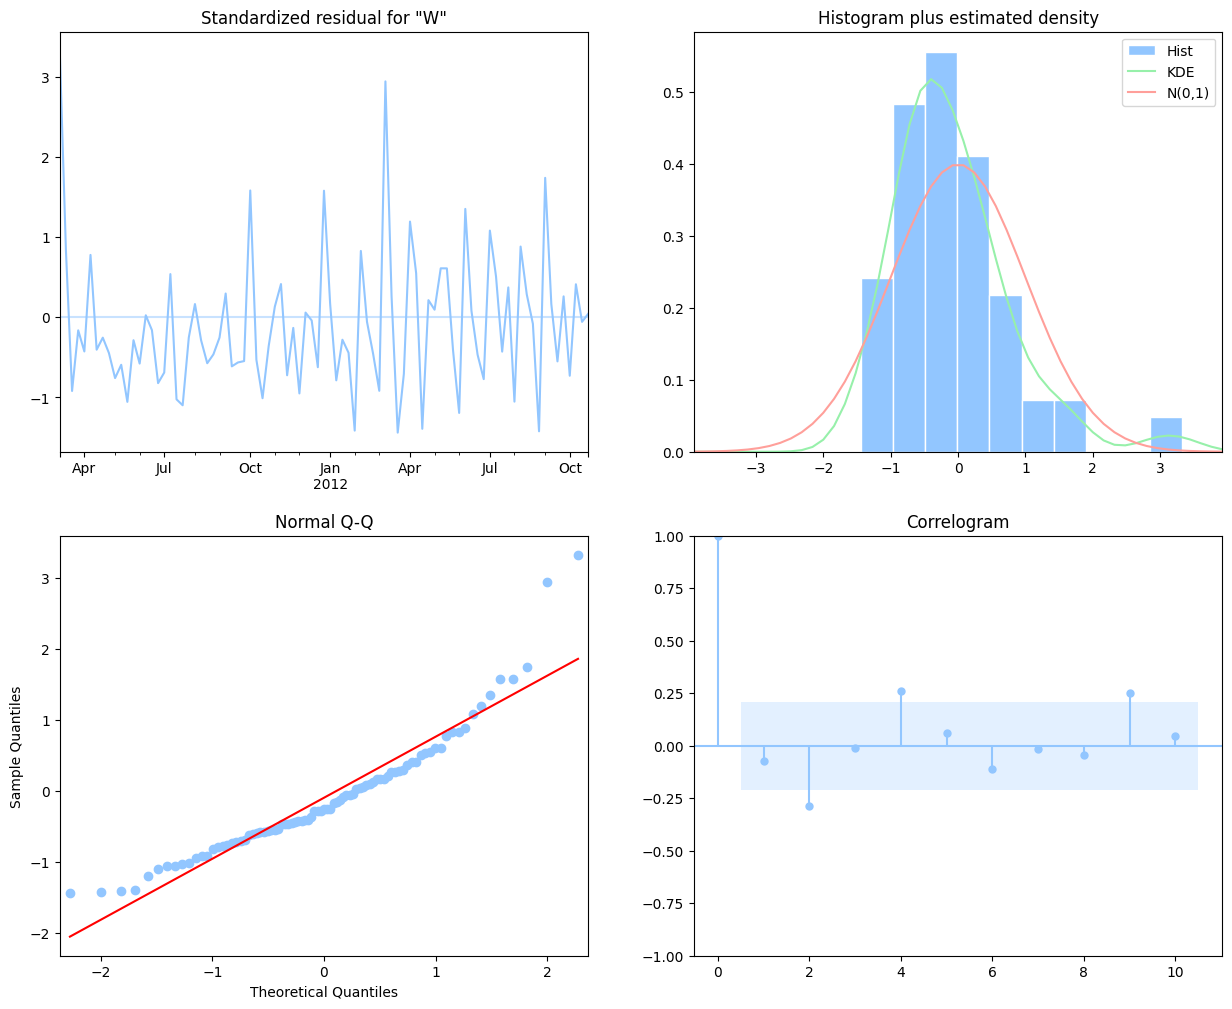

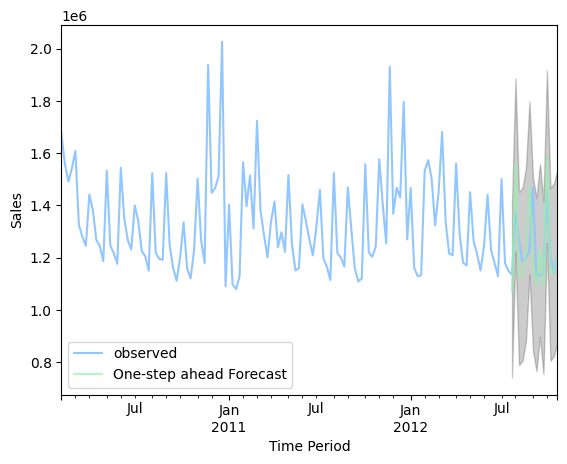

The Mean Squared Error of our forecasts is 16815046969.99


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



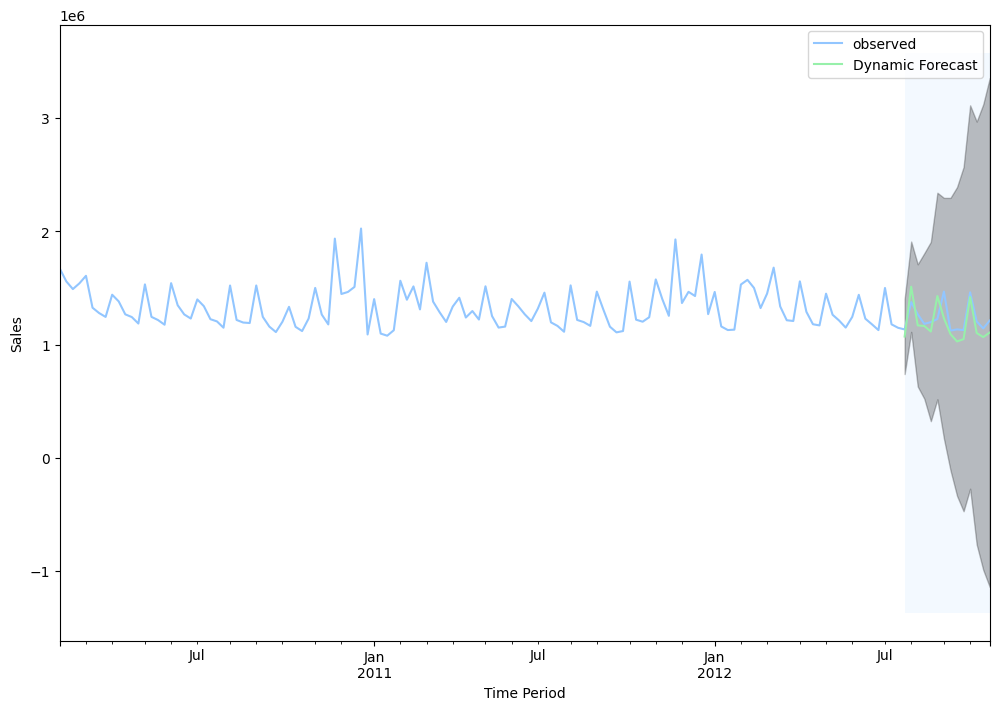

The Root Mean Squared Error of our forecasts is 114742.12
Residual for Store 28: 1381984.5038252233


            Lower Bound  Forecast  Upper Bound
2012-11-02      1180548   1510854      1841161
2012-11-09       941201   1337871      1734541
2012-11-16       642233   1177575      1712917
2012-11-23      1233287   1868446      2503605
2012-11-30       518769   1300072      2081375
2012-12-07       484469   1382672      2280876
2012-12-14       296778   1341564      2386351
2012-12-21       545059   1724737      2904416
2012-12-28      -220008   1114628      2449265
2013-01-04      -166916   1318541      2803997
2013-01-11      -655931    996029      2647988
2013-01-18      -867095    952281      2771656


In [26]:
# Ask user for the store number
store_id = int(input("Enter the store id to forecast sales: "))
forecast_store_sales(store_id)